<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод:</a></span></li><li><span><a href="#Подготовим-данные" data-toc-modified-id="Подготовим-данные-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовим данные</a></span></li><li><span><a href="#Визуализация-слов-из-разных-классов-с-помощью-метода-WordCloud" data-toc-modified-id="Визуализация-слов-из-разных-классов-с-помощью-метода-WordCloud-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Визуализация слов из разных классов с помощью метода WordCloud</a></span><ul class="toc-item"><li><span><a href="#Частотный-анализ-текста-в-нетоксичных-твитах" data-toc-modified-id="Частотный-анализ-текста-в-нетоксичных-твитах-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Частотный анализ текста в нетоксичных твитах</a></span></li><li><span><a href="#Частотный-анализ-текста-в-токсичных-твитах" data-toc-modified-id="Частотный-анализ-текста-в-токсичных-твитах-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Частотный анализ текста в токсичных твитах</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-LogisticRegression" data-toc-modified-id="Модель-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель LogisticRegression</a></span></li><li><span><a href="#Модель-LGBMClassifier" data-toc-modified-id="Модель-LGBMClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель LGBMClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загрузим необходимые библиотеки

In [ ]:
pip install wordcloud

     |████████████████████████████████| 458 kB 2.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import re
import nltk
import en_core_web_sm #spaCy
import spacy
import warnings
tqdm.pandas()

from tqdm.notebook import tqdm
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings('ignore')

Загрузим стоп-слова

In [ ]:
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Зададим необходимые настройки

In [ ]:
STATE = 12345
CV = KFold(n_splits=3, shuffle=True, random_state=STATE)
SCV = StratifiedKFold(n_splits=3)

Загрузим данные

In [ ]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0, sep=',')

Оценим структуру данных, выведем на экран 10 строк

In [ ]:
print('Структура данных:')
display(df.info())
display(df.sample(10))

Структура данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

,text,toxic
30296,"""\n\nPatrick sgarlata\nPlease stop. If you con...",0
86031,"""This is above Wikipedia's crystal ball policy...",0
47834,Thanks... \n\nThis Mahesh nonsense has taken u...,0
82415,"Your Mom Has A Penis!!!!! \n\nWow, she is hell...",1
21378,"""\n\n Message on my talk page \n\nWhy'd you le...",0
117661,"- Great analogy! BTW, I agree (entirely!) re ...",0
3738,"""Thank you for experimenting with the page Ben...",0
41420,User Page Revert! \n\nNo problem with the user...,0
61164,"""\n\n Re: Personal attacks \n\nI have removed ...",0
121341,"Good morrow to you, sir.",0


Найдем характерные значения таблицы df

In [ ]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
toxic,159292.0,0.101612,0.302139,0.0,0.0,0.0,0.0,1.0


Определим количество дублей

In [ ]:
print('Количество дублей:', df.duplicated().sum())

Количество дублей: 0


Определим дисбаланс классов в поле toxic

Процентное соотношение токсичных комментариев к обычным: 8.8


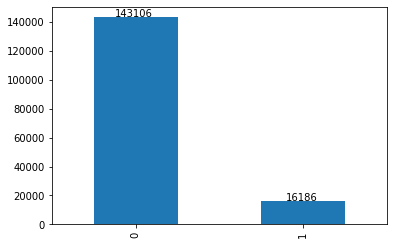

In [ ]:
ax = df['toxic'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.025+0.13, p.get_height() * 1.005))
print('Процентное соотношение токсичных комментариев к обычным:', np.round((df['toxic'].isin([0]).sum()/df['toxic'].isin([1]).sum()),decimals=1))

### Вывод:
Таблица toxic_comments.csv состоит из 159571 строк и 2 столбцов (разделитель - запятая):

- text - текст комментария на английском языке (тип - object);
> * текст не лемматизирован;
> * текст содержит лишние символы (перевода строки /n и д.р.).
- `toxic` - признак токсичности (тип - int64), целевой признак
> * датасет содержит ~ 9% токсичных комментариев;
> * наблюдается дисбаланс классов (используем параметр class_weight = balanced для логистической регрессии и StratifiedKFold для кросс-валидации)

### Подготовим данные

Создадим функцию очистки текста, лемматизации

In [ ]:
nlp = spacy.load ("en_core_web_sm")

def lemmatize_text(text):
    text = text.lower()
    doc = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in doc])
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text)
    return " ".join(cleared_text.split())

In [ ]:
%%time
df['text'] = df['text'].progress_apply(lemmatize_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 46min 17s, sys: 21.8 s, total: 46min 39s
Wall time: 47min 53s


In [ ]:
df.head()

,text,toxic
0,explanation why the edit make under my usernam...,0
1,d aww he match this background colour I be see...,0
2,hey man I be really not try to edit war it be ...,0
3,more I can not make any real suggestion on imp...,0
4,you sir be my hero any chance you remember wha...,0


### Визуализация слов из разных классов с помощью метода WordCloud

In [ ]:
df_0 = df.query('toxic == 0')
df_1 = df.query('toxic == 1')

text_0 = df_0['text'].str.cat(sep = ' ')
text_1 = df_1['text'].str.cat(sep = ' ')

In [ ]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud)
    plt.axis('off')

In [ ]:
def wc(text):
    wordcloud = WordCloud(width = 800,
                          height = 600,
                          random_state = STATE,
                          background_color = 'salmon',
                          colormap = 'Pastel1',
                          collocations = False,
                          stopwords = STOPWORDS).generate(text)

    plot_cloud(wordcloud)

#### Частотный анализ текста в нетоксичных твитах

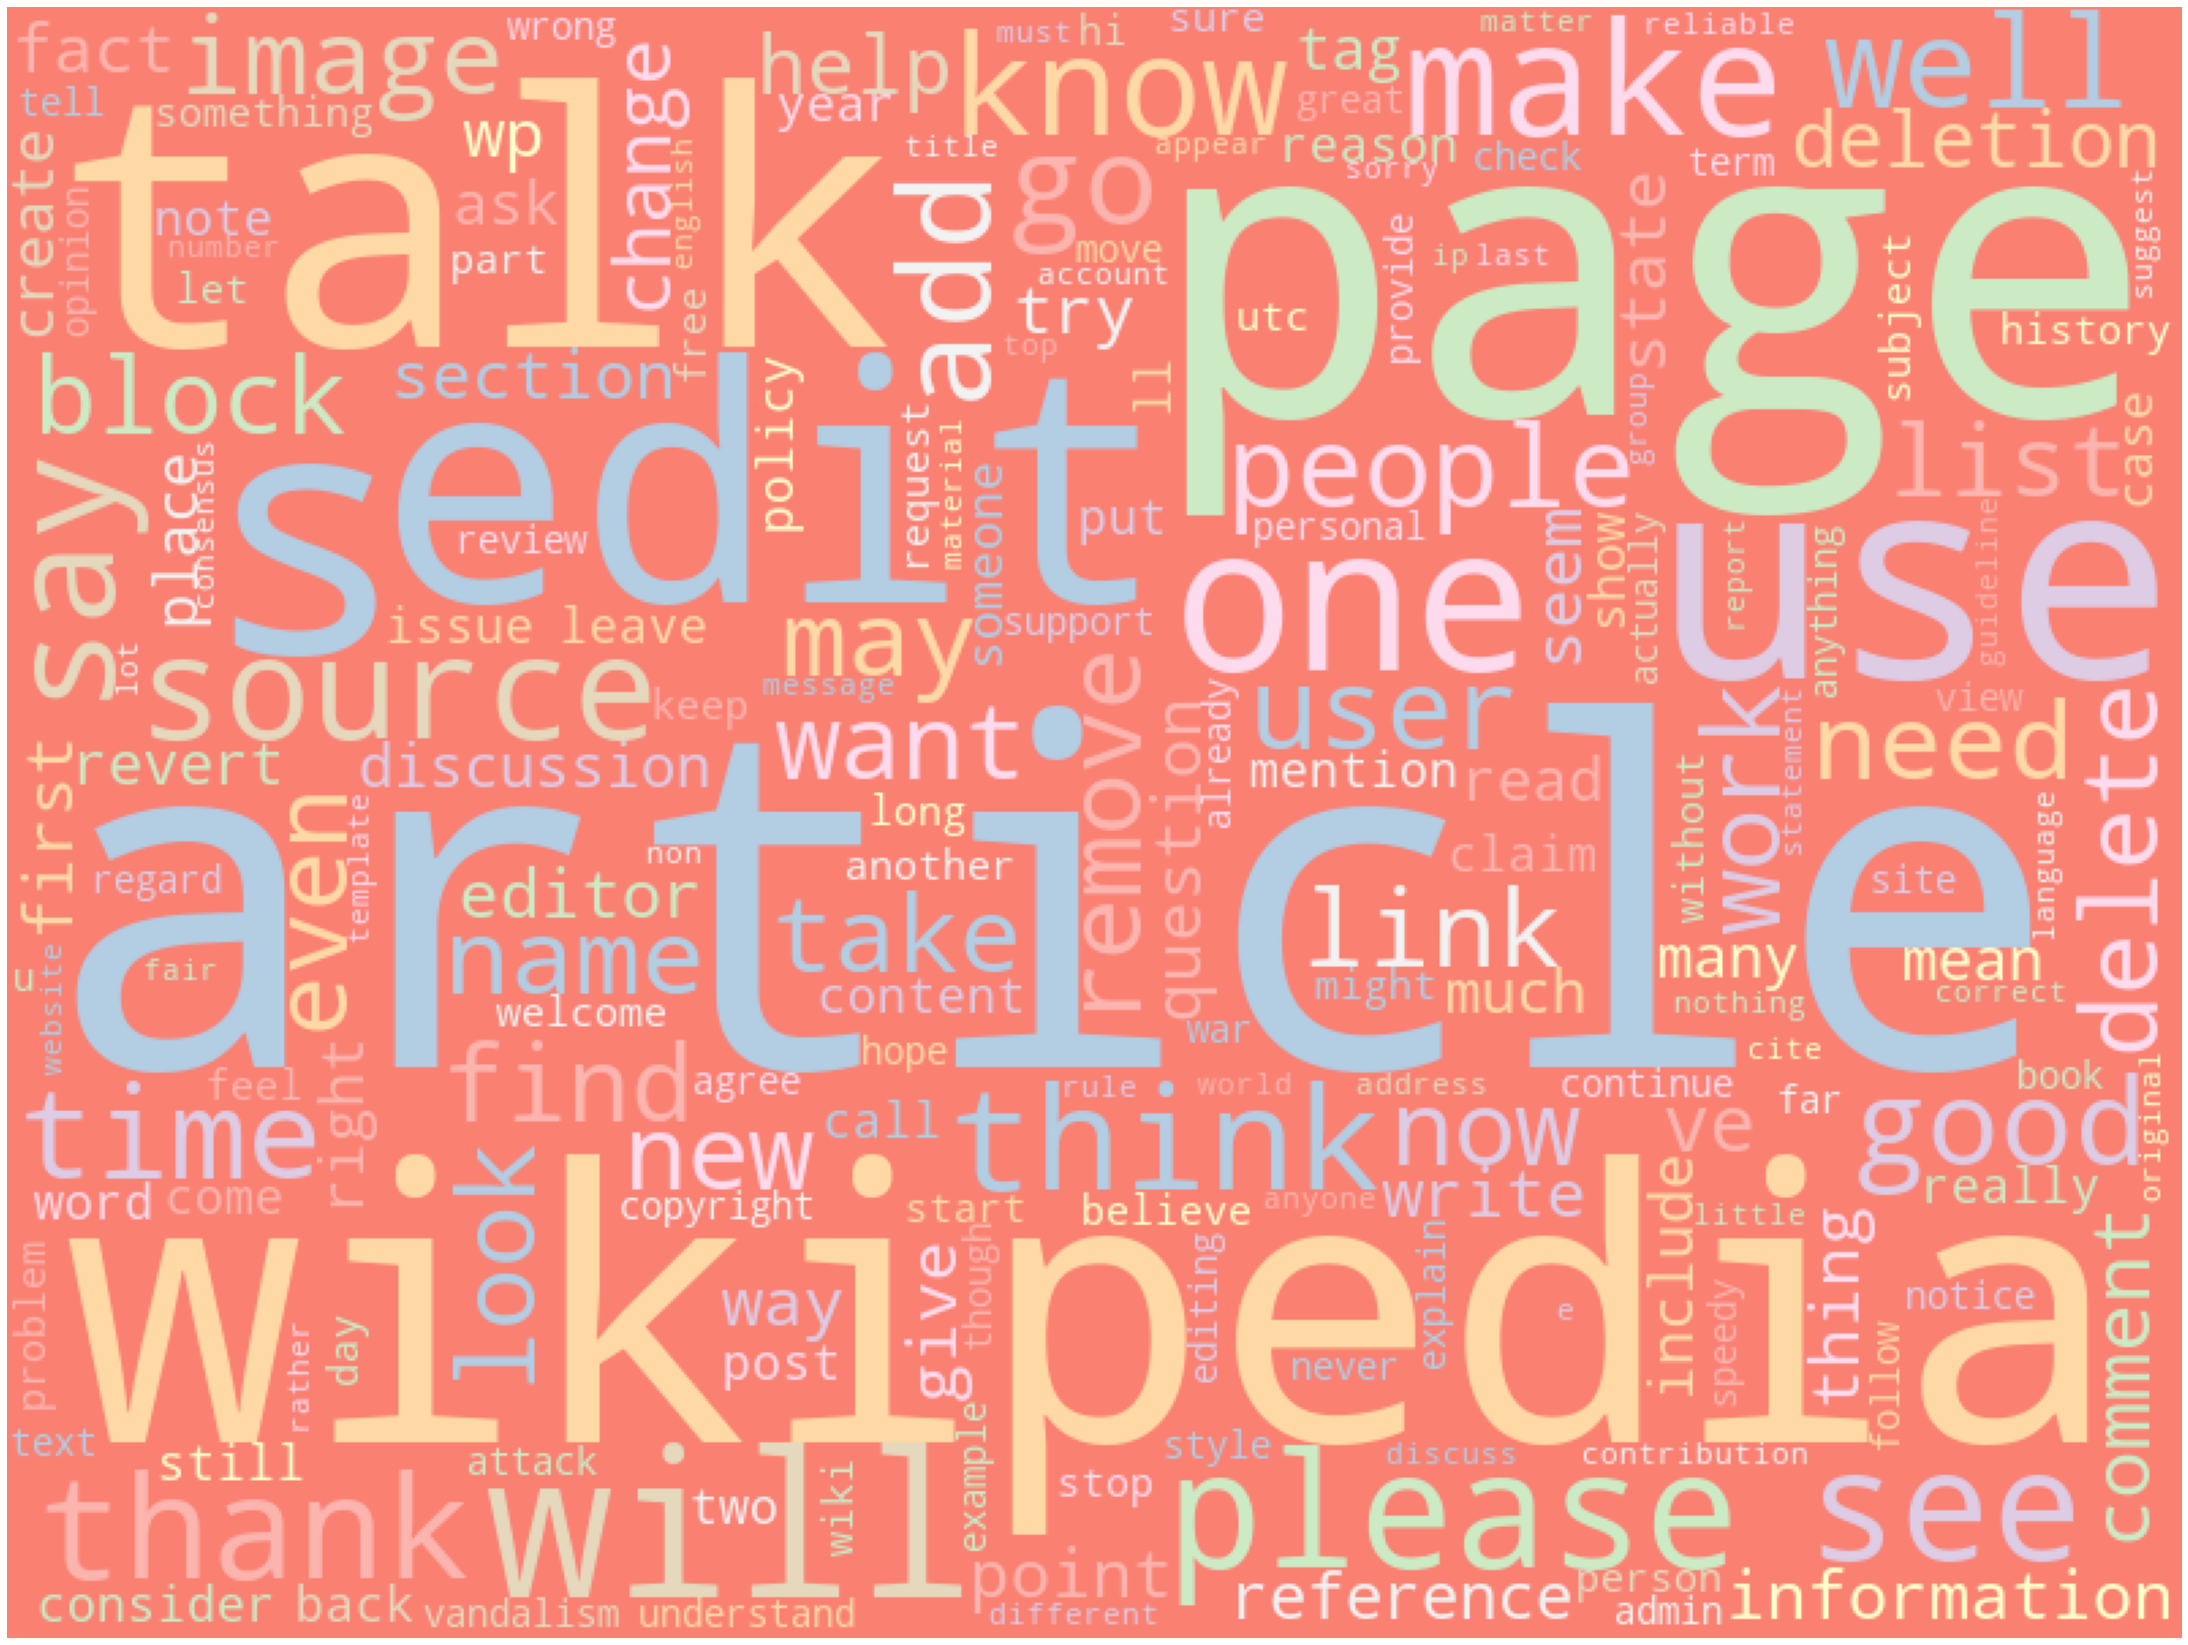

In [ ]:
wc(text_0)

#### Частотный анализ текста в токсичных твитах

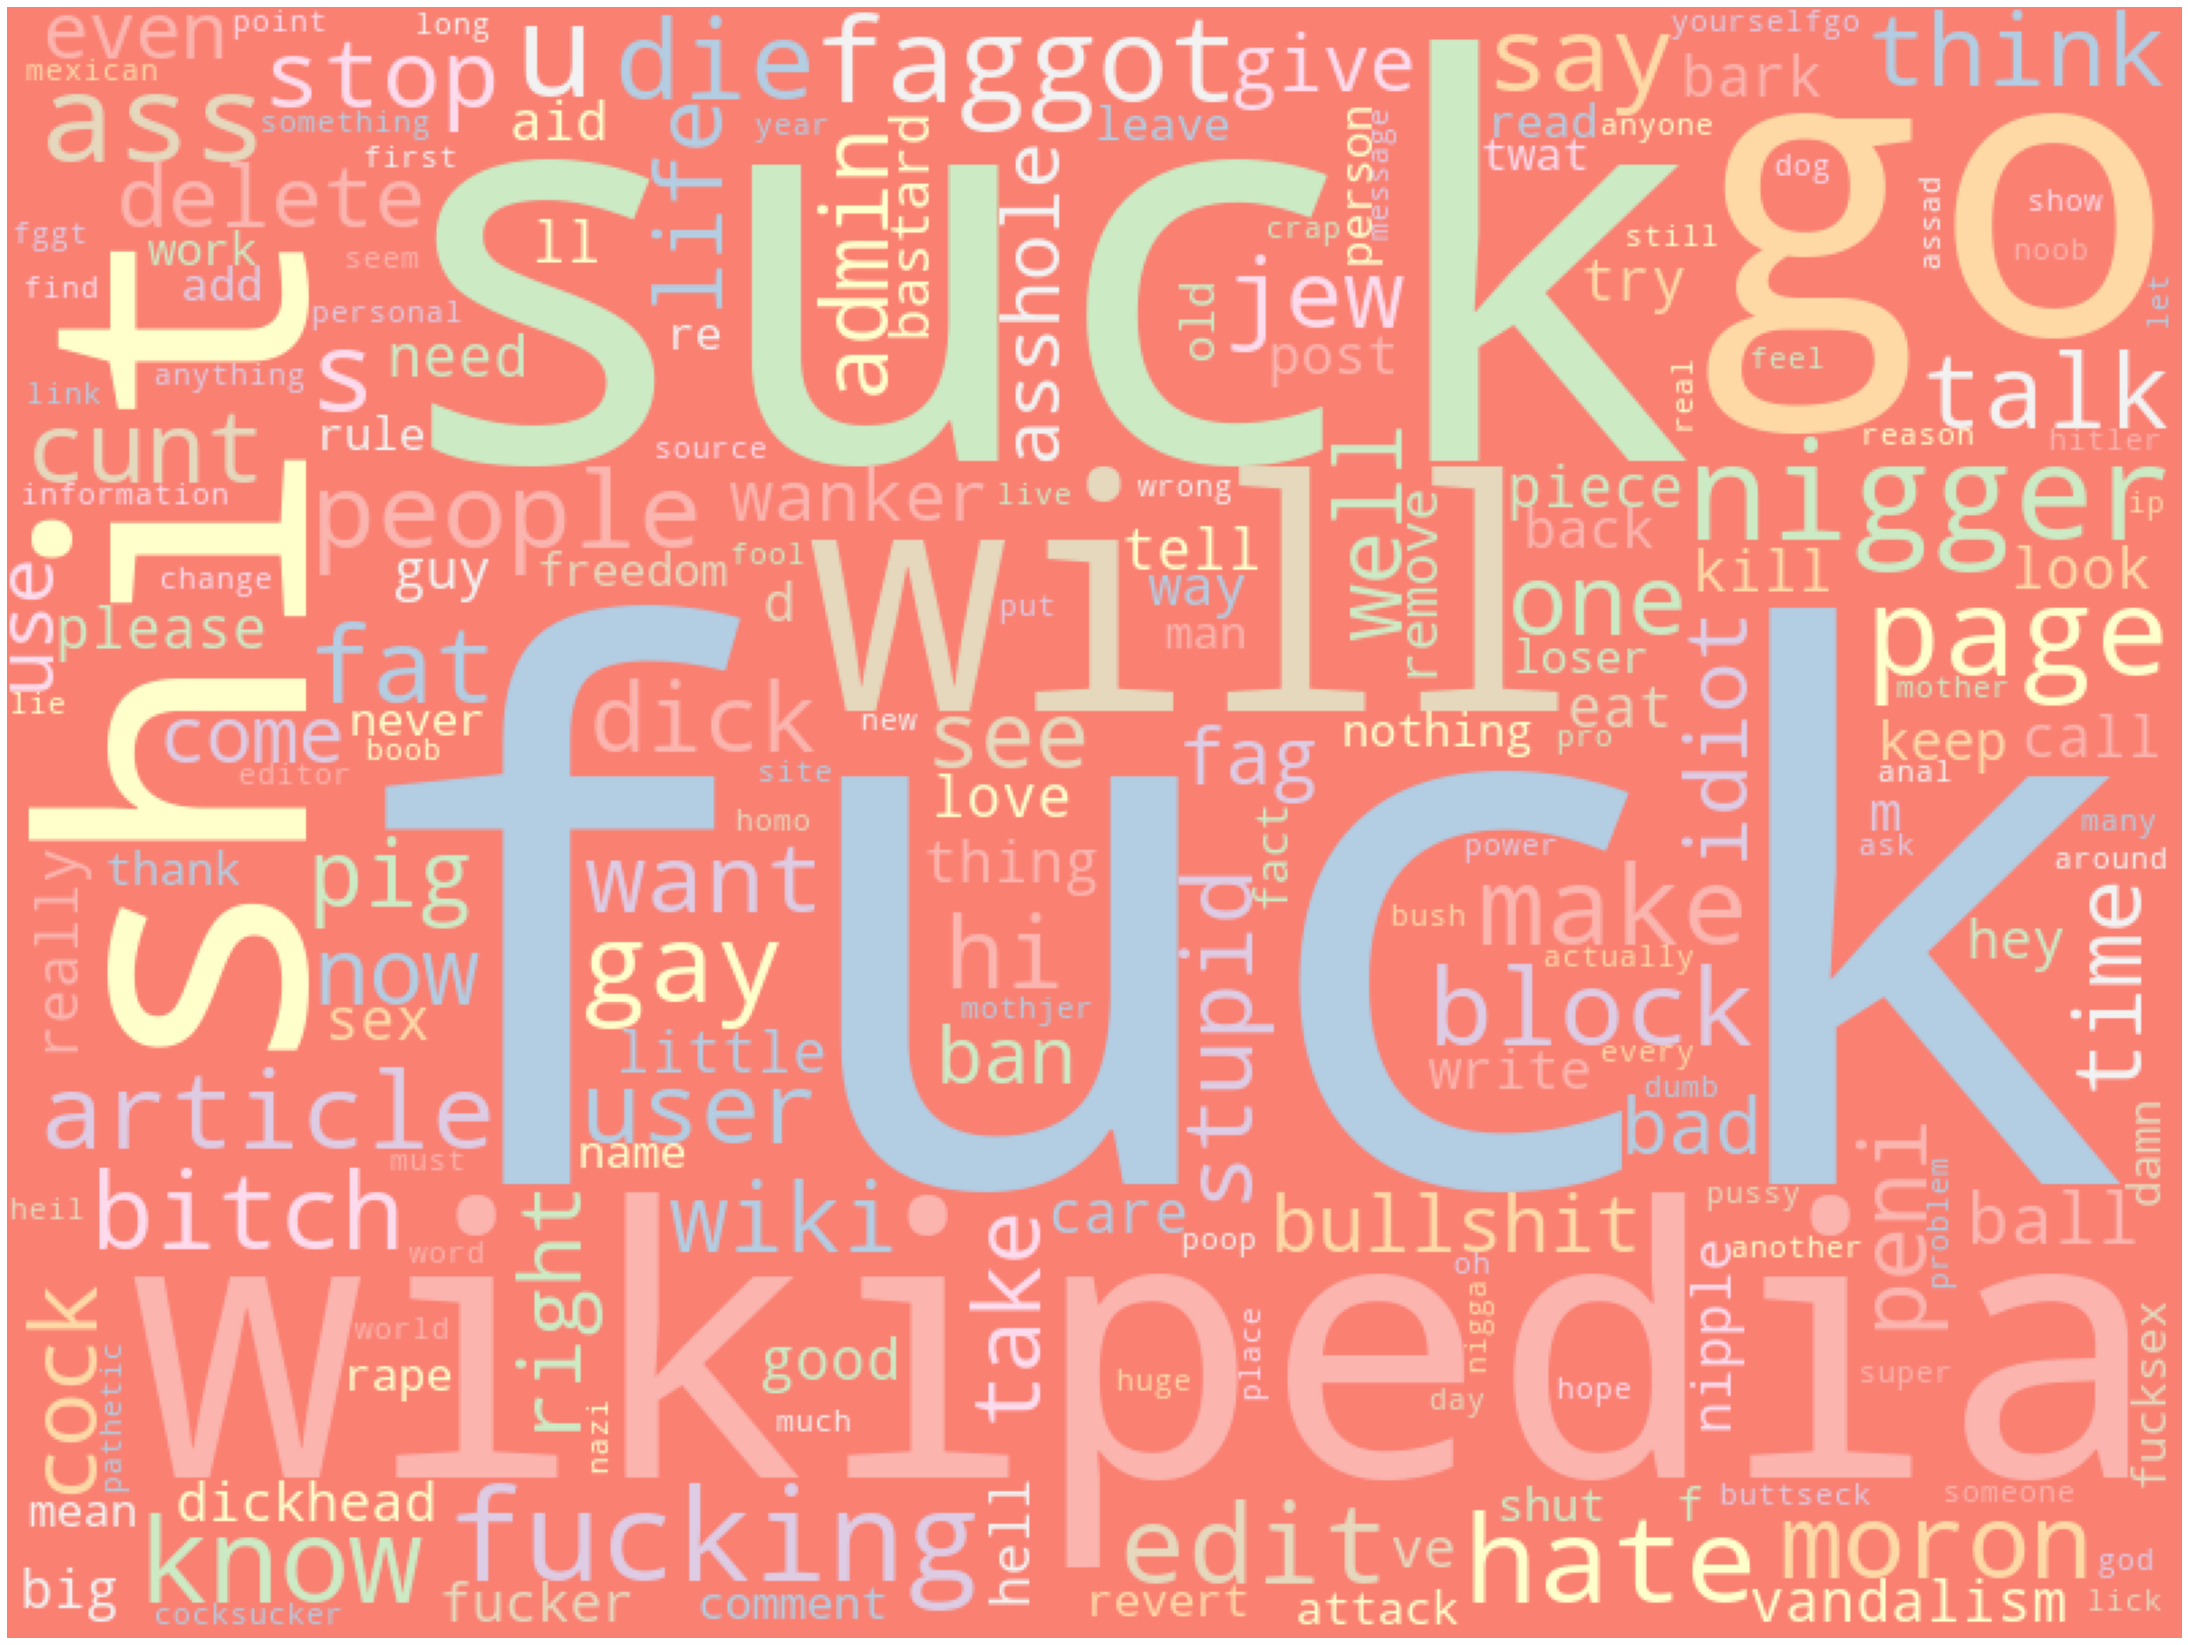

In [ ]:
wc(text_1)

Определим количество дублей после лемматизации

In [ ]:
print('Количество дублей:', df.duplicated().sum())

Количество дублей: 1309


Удалим полные дубли

In [ ]:
df = df.drop_duplicates().reset_index(drop = True)

Проверим удаление дублей

In [ ]:
print(df.shape)

(157983, 2)


## Обучение

Создадим переменные для признаков и целевого признака

In [ ]:
features = df.drop('toxic', axis=1)
target = df['toxic']

Разобъем данные на обучающую и тестовую выборки в соотношении 3:1, используем stratify чтобы сохранить пропорции классов

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                           random_state=STATE, stratify=target)

In [ ]:
#Проконтролируем размер новых выборок
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(118487, 1)
(118487,)
(39496, 1)
(39496,)


Уменьшим количество кроссвалидаций до 3 из-за размера выборки

In [ ]:
cv_counts = 3

### Модель LogisticRegression

In [ ]:
%%time

lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stop_words)),
    ('clf', LogisticRegression(random_state=STATE, max_iter=2000))])

lr_params = {'clf__C': [10],
          'clf__class_weight': ['balanced']}

lr_grid = GridSearchCV(estimator=lr_pipe, param_grid=lr_params, cv=cv_counts, scoring='f1', n_jobs=-1, refit=False)
lr_grid.fit(features_train['text'], target_train)
lr_best_paramms = lr_grid.best_params_

CPU times: user 3min 10s, sys: 2min 38s, total: 5min 48s
Wall time: 5min 49s


In [ ]:
print(lr_best_paramms)
print(lr_grid.best_score_)

{'clf__C': 10, 'clf__class_weight': 'balanced'}
0.7775973112641115


### Модель LGBMClassifier

In [ ]:
%%time

lgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stop_words)),
    ('clf', LGBMClassifier(random_state=STATE))])

lgb_params = {
  'clf__n_estimators': [200],
  'clf__learning_rate': [0.25],
  'clf__max_depth': [-1]}

lgb_grid = GridSearchCV(estimator=lgb_pipe, param_grid=lgb_params, cv=cv_counts, scoring='f1', n_jobs=-1, refit=False)
lgb_grid.fit(features_train['text'], target_train)
lgb_best_params = lgb_grid.best_params_

CPU times: user 13min 28s, sys: 7.54 s, total: 13min 36s
Wall time: 13min 39s


In [ ]:
print('Оптимальные параметры: ', lgb_best_params)
print(lgb_grid.best_score_)

Оптимальные параметры:  {'clf__learning_rate': 0.25, 'clf__max_depth': -1, 'clf__n_estimators': 200}
0.7750217075615025


Подобраны параметры с помощью GridSearchCV с расчетом TF-IDF

In [ ]:
vectorize = TfidfVectorizer(ngram_range=(1,3),
               min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stop_words)

In [ ]:
X_train = vectorize.fit_transform(features_train['text'])
X_test = vectorize.transform(features_test['text'])

In [ ]:
lr_m = LogisticRegression(C=10, class_weight='balanced', random_state=STATE)
lr_m.fit(X_train, target_train)

LogisticRegression(C=10, class_weight='balanced', random_state=12345)

In [ ]:
def scoring(fitted_model):
    test_pred = fitted_model.predict(X_test)
    test_f1 = f1_score(target_test, test_pred)

    print('F1 on test: {:.3f}'.format(test_f1))

Лучшей моделью со значением метрики качества F1 оказалась LogisticRegression со значением 0.7775973112641115, используем на тестовой выборке

In [ ]:
scoring(lr_m)

F1 on test: 0.780


По заданию нам необходимо было значение метрики качества F1 > 0.75, условие выполняется.

## Выводы

По заданию, магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. В нашем распоряжении был набор данных с разметкой о токсичности правок.  

Таблица `toxic_comments.csv` состоит из 159571 строк и 2 столбцов (разделитель - запятая). Столбец **text** - текст комментария на английском языке, **toxic** - признак токсичности, целевой признак.  

 - В ходе исследовательского анализа данных мы выяснили, что датасет содержит ~ 9% токсичных комментариев, наблюдается дисбаланс классов.  

 - В ходе подготовки данных мы очистили текст, провели лемматизацию.  

 - Визуализировали слова из разных классов с помощью метода `WordCloud` для графического отображения, чтобы получить общее представление о тематике и о наиболее часто встерчаемых словах в токсичных и нетоксичных твитах.

В рамках проекта была построена модель классификации токсичности комментариев пользователей (позитивные/негативные).  

Обучили две модели: `LogisticRegression`, `LGBMClassifier`
 - Все модели позволили достичь целевое значение метрики `F1-score`
 - Лучшей моделью со значением метрики качества F1 не меньше 0.77 оказалась `LogisticRegression` со значением `F1-score` `0.7775973112641115`.
 - `LogisticRegression` выдает на тестовой выборке результат `F1-score`: `0.78`, что удовлетворяет условиям задачи  

Таким образом, мы справились с поставленной задачей и для магазина "ВИКИШОП" можем смело рекомендовать к использованию в своей работе модель `LogisticRegresion`